## 5.1 実験候補の生成

In [1]:
# 5.1 実験候補の生成
import numpy as np
import polars as pl
from func import load_data

num_of_generating_samples = 10000  # 生成するサンプル数
desired_components_sum = 1  # 合計を指定する特徴量がある場合の、合計の値。例えば、この値を 100 にすれば、合計を 100 にできます

generation_settings = load_data("../test_data/setting_of_generation.csv").transpose(
    include_header=True, header_name="var", column_names=""
)
setting_items = generation_settings.columns[1:]  # varを除く設定項目名リスト
x_var_names = generation_settings.get_column("var")  # 特徴量名リスト
# 上、下限値を抽出
x_upper = generation_settings.get_column("upper").cast(pl.Float64)
x_lower = generation_settings.get_column("lower").cast(pl.Float64)
group_setting = generation_settings.get_column(
    "group with a total of desired_sum_of_components"
).cast(pl.Int64)
rounding = generation_settings.get_column("rounding").cast(pl.Int64)

# 0 から 1 の間の一様乱数でサンプル生成
rng = np.random.default_rng(99)
x_generated = pl.DataFrame(
    {
        col: rng.uniform(
            lower,
            upper,
            num_of_generating_samples,
        )
        for col, lower, upper in zip(x_var_names, x_lower, x_upper)
    }
)

# 合計を desired_components_sum にする特徴量がある場合
if sum(group_setting) != 0:
    var_groups = (
        pl.DataFrame({"vars": x_var_names, "group_no": group_setting})
        .group_by("group_no", maintain_order=True)
        .agg(pl.col("vars").implode())
    ).filter(pl.col("group_no") != 0)

    for grouped_vars in var_groups.get_column("vars"):
        x_generated = x_generated.with_columns(
            pl.col(grouped_vars)
            .truediv(pl.sum_horizontal(pl.col(grouped_vars)))
            .mul(desired_components_sum)
        )
    # 全変数が下限以上かつ上限未満である行のみ残す (各列ごとに [x_lower, x_upper) を満たすこと)
    mask = x_generated.select(
        [
            (pl.col(col) >= lower) & (pl.col(col) < upper)
            for col, lower, upper in zip(x_var_names, x_lower, x_upper)
        ]
    ).min_horizontal()
    x_generated = x_generated.filter(mask)

# 数値の丸め込みをする場合
if "rounding" in setting_items:
    x_generated = x_generated.with_columns(
        [
            pl.col(col)
            .mul(10**round_digit)
            .round(0, "half_away_from_zero")
            .truediv(10**round_digit)
            for col, round_digit in zip(x_var_names, rounding)
        ]
    )

# temperatureとtimeをint型に変換して、インデックスを追加してCSV出力
x_generated.with_columns(
    [
        pl.col("temperature").cast(pl.Int64),
        pl.col("time").cast(pl.Int64),
    ]
).with_row_index("").write_csv(
    "../output/05_01/generated_samples.csv", quote_style="never"
)


## 5.2 実験候補の選択

In [ ]:
# 5.2 実験候補の選択

import numpy as np
import polars as pl
from func import autoscaling, load_data

# 選択するサンプル数
number_of_selecting_samples = 30
# ランダムにサンプルを選択して D 最適基準を計算する繰り返し回数
num_of_random_searches = 1000

idx_col_name = ""
x_generated, index = load_data(
    "../output/05_01/generated_samples.csv", index=idx_col_name
)
autoscaled_x_generated = autoscaling(x_generated)
# index列を後で使うので再結合
x_generated_wt_index = x_generated.insert_column(0, index)
autoscaled_x_generated_wt_index = autoscaled_x_generated.insert_column(0, index)

# 乱数シードを固定
seed = 11
# rng = np.random.default_rng(seed)
# pl.set_random_seed(seed)

# D 最適基準に基づくサンプル選択
best_d_optimal_value = float("-inf")  # 初期値を設定
for random_search_number in range(num_of_random_searches):
    # 1. ランダムに候補を選択
    temp_samples_wt_index = autoscaled_x_generated_wt_index.sample(
        n=number_of_selecting_samples, with_replacement=False, shuffle=False, seed=seed
    )
    temp_indexes = temp_samples_wt_index[idx_col_name]
    temp_samples_np = temp_samples_wt_index.drop(idx_col_name).to_numpy()

    # 2. D 最適基準を計算
    xt_x = np.dot(temp_samples_np.T, temp_samples_np)  # X'X を計算
    temp_d_optimal_value: np.float64 = np.linalg.det(xt_x)  # D 最適基準を計算

    # 3. D 最適基準が前回までの最大値を上回ったら、選択された候補を更新
    if temp_d_optimal_value > best_d_optimal_value:
        best_d_optimal_value = temp_d_optimal_value.copy()
        selected_indexes = temp_indexes.implode()
        selected_samples_wt_index = x_generated_wt_index.filter(
            pl.col(idx_col_name).is_in(selected_indexes)
        )

# 保存
selected_samples_wt_index.write_csv(
    "../output/05_02/selected_samples.csv", quote_style="never"
)

# 選択されなかったサンプル
remaining_samples_wt_index = x_generated_wt_index.filter(
    ~pl.col(idx_col_name).is_in(selected_indexes)
)
remaining_samples_wt_index.write_csv(
    "../output/05_02/remaining_samples.csv", quote_style="never"
)

print(selected_samples_wt_index.drop(idx_col_name).corr())  # 相関行列の確認

shape: (5, 5)
┌────────────────┬────────────────┬────────────────┬─────────────┬───────────┐
│ raw material 1 ┆ raw material 2 ┆ raw material 3 ┆ temperature ┆ time      │
│ ---            ┆ ---            ┆ ---            ┆ ---         ┆ ---       │
│ f64            ┆ f64            ┆ f64            ┆ f64         ┆ f64       │
╞════════════════╪════════════════╪════════════════╪═════════════╪═══════════╡
│ 1.0            ┆ -0.453874      ┆ -0.690676      ┆ 0.248368    ┆ 0.154256  │
│ -0.453874      ┆ 1.0            ┆ -0.330204      ┆ -0.058324   ┆ 0.057684  │
│ -0.690676      ┆ -0.330204      ┆ 1.0            ┆ -0.218392   ┆ -0.200395 │
│ 0.248368       ┆ -0.058324      ┆ -0.218392      ┆ 1.0         ┆ -0.174707 │
│ 0.154256       ┆ 0.057684       ┆ -0.200395      ┆ -0.174707   ┆ 1.0       │
└────────────────┴────────────────┴────────────────┴─────────────┴───────────┘


## 5.3 次の実験候補の選択

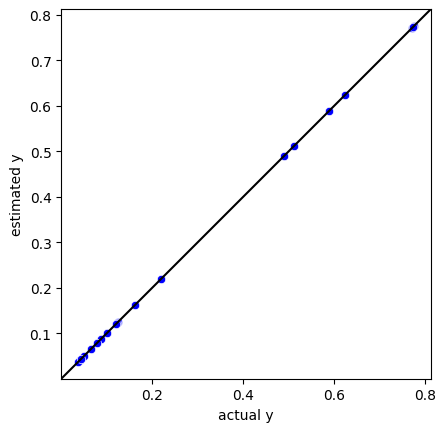

r^2 for training data : 0.9999999931263742
RMSE for training data : 2.2790784973808692e-05
MAE for training data : 1.7018909766406895e-05


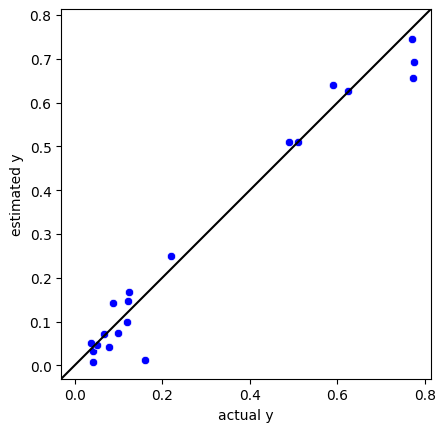

r^2 for training data : 0.9626474714375198
RMSE for training data : 0.05312835207520736
MAE for training data : 0.03772294067072186

トレーニングデータにおけるサポートベクター数 :10
トレーニングデータにおけるサポートベクターの割合 :0.5
トレーニングデータにおける外れサンプル数 :4
トレーニングデータにおける外れサンプルの割合 :0.2

予測用データセットにおける外れサンプル数 :4387 
予測用データセットにおける外れサンプルの割合 :0.451198189859097


In [23]:
# 5.3 次の実験候補の選択

import warnings

import polars as pl
from func import (
    add_sqrt_and_interaction_terms,
    autoscaling,
    calc_ad_by_knn,
    calc_ad_by_ocsvm,
    calc_optimal_gamma,
    calc_r2,
    delete_zero_std_columns,
    generate_kernels,
    load_data,
    optimize_hyperparameters_by_cv,
    optimize_hyperparameters_by_gs,
    rescaling,
    scatter_plot_of_result,
    show_fitting_evaluation,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.svm import SVR, OneClassSVM

warnings.filterwarnings("ignore")

regression_method = "gpr_one_kernel"  # 回帰分析手法 'ols_linear', 'ols_nonlinear', 'svr_linear', 'svr_gaussian', 'gpr_one_kernel', 'gpr_kernels'
ad_method = "ocsvm"  # AD設定手法 'knn', 'ocsvm', 'ocsvm_gamma_optimization'

fold_number = 10  # クロスバリデーションの fold 数
# AD 内となるトレーニングデータの割合。AD　のしきい値を決めるときに使用
rate_of_training_samples_within_ad = 0.96

# 線形SVRのハイパーパラメータ
linear_svr_cs = 2.0 ** pl.arange(-10, 5, eager=True)  # C の候補
linear_svr_epsilons = 2.0 ** pl.arange(-10, 0, eager=True)  # ε の候補

# 非線形SVRのハイパーパラメータ
nonlinear_svr_cs = 2.0 ** pl.arange(-5, 10, eager=True)  # C の候補
nonlinear_svr_epsilons = 2.0 ** pl.arange(-10, 0, eager=True)  # ε の候補
nonlinear_svr_gammas = 2.0 ** pl.arange(-20, 10, eager=True)  # γ の候補
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10

# k-NN における k
k_in_knn = 5

# OCSVMのハイパーパラメータ
ocsvm_nu = 0.04  # OCSVM における ν。トレーニングデータにおけるサンプル数に対する、サポートベクターの数の下限の割合
ocsvm_gamma = 0.1  # OCSVM における γ
ocsvm_gammas = 2.0 ** pl.arange(-20, 11, eager=True)  # γ の候補

# トレーニングデータの読み込み
dataset_train, index_train = load_data("../test_data/resin.csv", index="")
# データ分割
y_train = dataset_train.get_column("property")  # 目的変数
x_train = dataset_train.drop(y_train.name)  # 説明変数
# 予測データの読み込み
dataset_pred, index_pred = load_data("../output/05_02/remaining_samples.csv", index="")
x_pred = dataset_pred.clone()

if regression_method == "ols_nonlinear":
    print("\n二乗項と交差項の追加")
    x_train = add_sqrt_and_interaction_terms(x_train)
    x_pred = add_sqrt_and_interaction_terms(x_pred)

# 標準偏差が 0 の特徴量の削除
x_train = delete_zero_std_columns(x_train)
x_pred = x_pred.select(x_train.columns)

# オートスケーリング
autoscaled_y_train = autoscaling(y_train)
autoscaled_x_train = autoscaling(x_train)
autoscaled_x_pred = autoscaling(x_pred, x_train)

# モデル構築
if regression_method == "ols_linear" or regression_method == "ols_nonlinear":
    model = LinearRegression()

elif regression_method == "svr_linear":
    # クロスバリデーションによる C, ε の最適化
    # クロスバリデーションの分割の設定
    cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
    # グリッドサーチの設定
    best_params = optimize_hyperparameters_by_gs(
        SVR(),
        autoscaled_x_train,
        autoscaled_y_train,
        param_grid={
            "C": linear_svr_cs.to_numpy(),
            "epsilon": linear_svr_epsilons.to_numpy(),
        },
        cv=cv,
        kernel="linear",
    )
    # SVRモデルの宣言
    model = SVR(kernel="linear", C=best_params["C"], epsilon=best_params["epsilon"])

elif regression_method == "svr_gaussian":
    # クロスバリデーションの分割の設定
    cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
    # C, ε, γの最適化
    optimal_nonlinear_c, optimal_nonlinear_epsilon, optimal_nonlinear_gamma = (
        optimize_hyperparameters_by_cv(
            SVR(),
            autoscaled_x_train,
            autoscaled_y_train,
            y_train,
            param_grid={
                "C": nonlinear_svr_cs.to_numpy(),
                "epsilon": nonlinear_svr_epsilons.to_numpy(),
                "gamma": nonlinear_svr_gammas.to_numpy(),
            },
            cv=cv,
            kernel="rbf",
        )
    )
    # モデル構築
    # SVR モデルの宣言
    model = SVR(
        kernel="rbf",
        C=optimal_nonlinear_c,
        epsilon=optimal_nonlinear_epsilon,
        gamma=optimal_nonlinear_gamma,
    )

elif regression_method == "gpr_one_kernel":
    # カーネル 11 種類
    kernels = generate_kernels(x_train)
    selected_kernel = kernels[kernel_number]
    model = GaussianProcessRegressor(alpha=0, kernel=selected_kernel, random_state=99)

elif regression_method == "gpr_kernels":
    # カーネル 11 種類
    kernels = generate_kernels(x_train)
    # クロスバリデーションによるカーネル関数の最適化
    # クロスバリデーションの分割の設定
    cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
    r2_cvs = pl.Series(
        "r2_cvs",
        [
            calc_r2(
                GaussianProcessRegressor,
                autoscaled_x_train,
                autoscaled_y_train,
                cv,
                y_train,
                kernel=kernel,
            )
            for kernel in kernels
        ],
    )
    optimal_kernel = kernels[r2_cvs.arg_max()]  # r2が最も大きい(最適な)カーネル関数
    print("クロスバリデーションで選択されたカーネル関数 :", optimal_kernel)

    # モデル構築
    model = GaussianProcessRegressor(
        alpha=0, kernel=optimal_kernel, random_state=99
    )  # GPR モデルの宣言

model.fit(autoscaled_x_train, autoscaled_y_train)  # モデル構築

# 標準回帰係数
if regression_method in ["ols_linear", "ols_nonlinear", "svr_linear"]:
    if regression_method == "svr_linear":
        coefs = model.coef_.T
    else:
        coefs = model.coef_

    pl.DataFrame(
        {
            "": x_train.columns,
            "standard_regression_coefficients": coefs.flatten(),
        }
    ).write_csv(
        f"../output/05_03/standard_regression_coefficients_{regression_method}.csv",
        quote_style="never",
    )

# トレーニングデータの推定
autoscaled_estimated_y = pl.Series(model.predict(autoscaled_x_train))
estimated_y = rescaling(autoscaled_estimated_y, y_train)

# トレーニングデータの実測値 vs. 推定値のプロット
scatter_plot_of_result(
    f"../output/05_03/actual_vs_estimated_y_train_{regression_method}.png",
    y_train,
    estimated_y,
    "actual y",
    "estimated y",
)

# トレーニングデータのr2, RMSE, MAE
show_fitting_evaluation(y_train, estimated_y)

# トレーニングデータの結果の保存
pl.DataFrame(
    {
        "": index_train,
        "actual_y": y_train,
        "estimated_y": estimated_y,
        "error_of_y(actual_y-estimated_y)": y_train - estimated_y,
    }
).write_csv(
    f"../output/05_03/estimated_y_in_detail_{regression_method}.csv",
    quote_style="never",
)

# クロスバリデーションによる y の値の推定
cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
autoscaled_estimated_y_in_cv = pl.Series(
    cross_val_predict(model, autoscaled_x_train, autoscaled_y_train, cv=cv)
)
estimated_y_in_cv = rescaling(autoscaled_estimated_y_in_cv, y_train)

# クロスバリデーションにおける実測値 vs. 推定値のプロット
scatter_plot_of_result(
    f"../output/05_03/actual_vs_estimated_y_in_cv_{regression_method}.png",
    y_train,
    estimated_y_in_cv,
    "actual y",
    "estimated y",
)

# クロスバリデーションにおけるr2, RMSE, MAE
show_fitting_evaluation(y_train, estimated_y_in_cv)

# クロスバリデーションの結果の保存
pl.DataFrame(
    {
        "": index_train,
        "actual_y": y_train,
        "estimated_y": estimated_y_in_cv,
        "error_of_y(actual_y-estimated_y)": y_train - estimated_y_in_cv,
    }
).write_csv(
    f"../output/05_03/estimated_y_in_cv_in_detail_{regression_method}.csv",
    quote_style="never",
)

# 予測
if regression_method in ["gpr_one_kernel", "gpr_kernels"]:
    estimated_y_pred, estimated_y_pred_std = model.predict(
        autoscaled_x_pred, return_std=True
    )
    # スケールを戻す
    estimated_y_pred = rescaling(pl.Series(estimated_y_pred), y_train)
    estimated_y_pred_std = rescaling(
        pl.Series(estimated_y_pred_std), y_train, is_std=True
    )
    # csv保存
    pl.DataFrame(
        {
            "": index_pred,
            "estimated_y": estimated_y_pred,
            "std_of_estimated_y": estimated_y_pred_std,
        }
    ).write_csv(f"../output/05_03/estimated_y_prediction_{regression_method}.csv")
else:
    estimated_y_pred = pl.Series("estimated_y", model.predict(x_pred))
    # csv保存
    pl.DataFrame({"": index_pred, "estimated_y": estimated_y_pred}).write_csv(
        f"../output/05_03/estimated_y_prediction_{regression_method}.csv"
    )

# ADの前処理(ols_nonlinearのみ)
if regression_method == "ols_nonlinear":
    # x_trainやx_predは非線形変換済みなので、AD前に元に戻してから処理する
    # この時点のx_train, x_predは、
    # 非線形変換や、std=0の特徴量を削除したデータなので、オリジナルを再取得
    x_train = dataset_train.drop(y_train.name)
    x_pred = dataset_pred.clone()

    # std=0 削除
    x_train = delete_zero_std_columns(x_train)
    x_pred = x_pred.select(x_train.columns)

    # オートスケーリング
    autoscaled_x_train = autoscaling(x_train)
    autoscaled_x_pred = autoscaling(x_pred, x_train)

# AD
if ad_method == "knn":
    mean_of_knn_distance_train, within_ad_flag_train, ad_threshold_train = (
        calc_ad_by_knn(
            autoscaled_x_train,
            n_neighbors=k_in_knn,
            ad_threshold=rate_of_training_samples_within_ad,
            remove_self=True,
        )
    )
    pl.DataFrame(
        {
            "": index_train,
            "mean_of_knn_distance": mean_of_knn_distance_train,
            "within_ad": within_ad_flag_train,
        }
    ).write_csv("../output/05_03/mean_of_knn_distance_train.csv", quote_style="never")

    # 予測用データに対して同様の処理を行う
    mean_of_knn_distance_pred, within_ad_flag_pred, ad_threshold_pred = calc_ad_by_knn(
        autoscaled_x_pred,
        n_neighbors=k_in_knn,
        ad_threshold=rate_of_training_samples_within_ad,
        remove_self=False,
    )
    pl.DataFrame(
        {
            "": index_pred,
            "mean_of_knn_distance": mean_of_knn_distance_pred,
            "within_ad": within_ad_flag_pred,
        }
    )
    ad_index_pred = mean_of_knn_distance_pred

elif ad_method == "ocsvm":
    if ad_method == "ocsvm_gamma_optimization":
        # グラム行列の分散が最大となるγを探索
        optimal_gamma = calc_optimal_gamma(autoscaled_x_train, ocsvm_gammas)
        print("最適化された gamma :", optimal_gamma)
    else:
        optimal_gamma = ocsvm_gamma

    # モデルを構築
    ad_model = OneClassSVM(kernel="rbf", gamma=optimal_gamma, nu=ocsvm_nu)
    ad_model.fit(autoscaled_x_train)

    # トレーニングデータを処理
    data_density_train, within_ad_flag_train = calc_ad_by_ocsvm(
        ad_model, autoscaled_x_train, train_data=True
    )
    pl.DataFrame(
        {
            "": index_train,
            "ocsvm_data_density": data_density_train,
            "within_ad_flag": within_ad_flag_train,
        }
    ).write_csv("../output/05_03/ocsvm_data_density_train.csv", quote_style="never")

    # 予測用データセットも同様に処理
    data_density_pred, within_ad_flag_pred = calc_ad_by_ocsvm(
        ad_model, autoscaled_x_pred, train_data=False
    )
    pl.DataFrame(
        {
            "": index_pred,
            "ocsvm_data_density": data_density_pred,
            "within_ad_flag": within_ad_flag_pred,
        }
    ).write_csv(
        "../output/05_03/ocsvm_data_density_prediction.csv", quote_style="never"
    )


# AD外の予測値をマスク
estimated_y_pred[~within_ad_flag_pred] = float("-inf")

# 保存
pl.DataFrame({"": index_pred, "ad_index_prediction": data_density_pred}).write_csv(
    f"../output/05_03/ad_index_prediction_{ad_method}.csv", quote_style="never"
)
pl.DataFrame({"": index_pred, "estimated_y": estimated_y_pred}).write_csv(
    f"../output/05_03/estimated_y_prediction_considering_ad_{regression_method}_{ad_method}.csv"
)

# 次のサンプル
next_sample = x_pred.insert_column(0, index_pred).slice(estimated_y_pred.arg_max(), 1)
next_sample.write_csv(
    f"../output/05_03/next_sample_{regression_method}_{ad_method}.csv"
)


## 5.4 ベイズ最適化

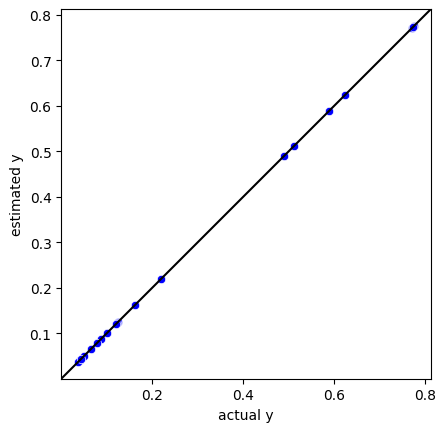

r^2 for training data : 0.9999999931263742
RMSE for training data : 2.2790784973808692e-05
MAE for training data : 1.7018909766406895e-05


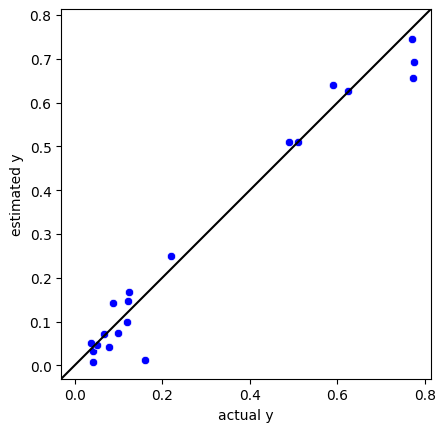

r^2 for training data : 0.9626474714375198
RMSE for training data : 0.05312835207520736
MAE for training data : 0.03772294067072186


In [3]:
# 5.4 ベイズ最適化
import warnings

import polars as pl
from func import (
    autoscaling,
    calc_acquisition_func,
    calc_r2,
    delete_zero_std_columns,
    generate_kernels,
    load_data,
    rescaling,
    scatter_plot_of_result,
    show_fitting_evaluation,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import KFold, cross_val_predict

warnings.filterwarnings("ignore")

regression_method = "gpr_one_kernel"  # 'gpr_one_kernel', 'gpr_kernels'
acquisition_function = "PTR"  # 'PTR', 'PI', 'EI', 'MI'

fold_number = 10  # クロスバリデーションの fold 数
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
target_range = [0, 1]  # PTR
relaxation = 0.01  # EI, PI
delta = 1e-6  # MI

# トレーニングデータの読み込み
dataset_train, index_train = load_data("../test_data/resin.csv", index="")
# データ分割
y_train = dataset_train.get_column("property")  # 目的変数
x_train = dataset_train.drop(y_train.name)  # 説明変数
# 予測データの読み込み
dataset_pred, index_pred = load_data("../output/05_02/remaining_samples.csv", index="")
x_pred = dataset_pred.clone()

# 標準偏差が 0 の特徴量の削除
x_train = delete_zero_std_columns(x_train)
x_pred = x_pred.select(x_train.columns)

# オートスケーリング
autoscaled_y_train = autoscaling(y_train)
autoscaled_x_train = autoscaling(x_train)
autoscaled_x_pred = autoscaling(x_pred, x_train)

# カーネル 11 種類
kernels = generate_kernels(x_train)

# モデル構築
if regression_method == "gpr_one_kernel":
    selected_kernel = kernels[kernel_number]
    model = GaussianProcessRegressor(alpha=0, kernel=selected_kernel, random_state=99)

elif regression_method == "gpr_kernels":
    # クロスバリデーションによるカーネル関数の最適化
    # クロスバリデーションの分割の設定
    cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
    r2_cvs = pl.Series(
        "r2_cvs",
        [
            calc_r2(
                GaussianProcessRegressor,
                autoscaled_x_train,
                autoscaled_y_train,
                cv,
                y_train,
                kernel=kernel,
                random_state=99,
            )
            for kernel in kernels
        ],
    )
    optimal_kernel = kernels[r2_cvs.arg_max()]  # r2が最も大きい(最適な)カーネル関数
    print("クロスバリデーションで選択されたカーネル関数 :", optimal_kernel)

    # モデル構築 GPR モデルの宣言
    model = GaussianProcessRegressor(alpha=0, kernel=optimal_kernel, random_state=99)

model.fit(autoscaled_x_train, autoscaled_y_train)  # モデル構築

# トレーニングデータの推定
autoscaled_estimated_y, autoscaled_estimated_y_std = model.predict(
    autoscaled_x_train, return_std=True
)
estimated_y = rescaling(pl.Series("estimated_y", autoscaled_estimated_y), y_train)
estimated_y_std = rescaling(
    pl.Series("std_of_estimated_y", autoscaled_estimated_y_std), y_train, is_std=True
)

# トレーニングデータの実測値 vs. 推定値のプロット
scatter_plot_of_result(
    f"../output/05_04/actual_vs_estimated_y_{regression_method}.png",
    y_train,
    estimated_y,
    "actual y",
    "estimated y",
)

# トレーニングデータのr2, RMSE, MAE
show_fitting_evaluation(y_train, estimated_y)

# トレーニングデータの結果の保存
pl.DataFrame(
    {
        "": index_train,
        "actual_y": y_train,
        "estimated_y": estimated_y,
        "error_of_y(actual_y-estimated_y)": y_train - estimated_y,
    }
).write_csv(
    f"../output/05_04/estimated_y_in_detail_{regression_method}.csv",
    quote_style="never",
)

# クロスバリデーションによる y の値の推定
cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
autoscaled_estimated_y_in_cv = pl.Series(
    cross_val_predict(model, autoscaled_x_train, autoscaled_y_train, cv=cv)
)
estimated_y_in_cv = rescaling(autoscaled_estimated_y_in_cv, y_train)

# クロスバリデーションにおける実測値 vs. 推定値のプロット
scatter_plot_of_result(
    f"../output/05_04/actual_vs_estimated_y_in_cv_{regression_method}.png",
    y_train,
    estimated_y_in_cv,
    "actual y",
    "estimated y",
)

# クロスバリデーションにおけるr2, RMSE, MAE
show_fitting_evaluation(y_train, estimated_y_in_cv)

# クロスバリデーションの結果の保存
pl.DataFrame(
    {
        "": index_train,
        "actual_y": y_train,
        "estimated_y": estimated_y_in_cv,
        "error_of_y(actual_y-estimated_y)": y_train - estimated_y_in_cv,
    }
).write_csv(
    f"../output/05_04/estimated_y_in_cv_in_detail_{regression_method}.csv",
    quote_style="never",
)

# 予測
estimated_y_pred, estimated_y_pred_std = model.predict(
    autoscaled_x_pred, return_std=True
)
# スケールを戻す
estimated_y_pred = rescaling(pl.Series(estimated_y_pred), y_train)
estimated_y_pred_std = rescaling(pl.Series(estimated_y_pred_std), y_train, is_std=True)

# csv保存
pl.DataFrame(
    {
        "": index_pred,
        "estimated_y": estimated_y_pred,
        "std_of_estimated_y": estimated_y_pred_std,
    }
).write_csv(f"../output/05_04/estimated_y_prediction_{regression_method}.csv")

# 獲得関数の計算
acquisition_function_prediction, _ = calc_acquisition_func(
    estimated_y_pred,
    estimated_y_pred_std,
    acquisition_function,
    target_range,
    relaxation,
    delta,
)

# csv保存
pl.DataFrame(
    {
        "": index_pred,
        "acquisition_function": acquisition_function_prediction,
        "std_of_estimated_y": estimated_y_pred_std,
    }
).write_csv(
    f"../output/05_04/acquisition_function_prediction_{regression_method}_{acquisition_function}.csv",
    quote_style="never",
)

# 次のサンプル
next_sample = x_pred.insert_column(0, index_pred).slice(
    acquisition_function_prediction.arg_max(), 1
)
next_sample.write_csv(
    f"../output/05_04/next_sample_{regression_method}_{acquisition_function}.csv"
)


## 5.4.1 ベイズ最適化による実験候補の選択

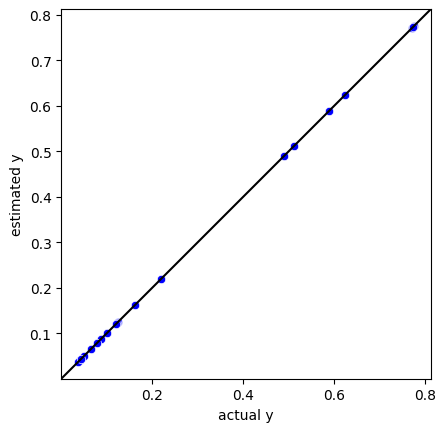

r^2 for training data : 0.9999999931263742
RMSE for training data : 2.2790784973808692e-05
MAE for training data : 1.7018909766406895e-05


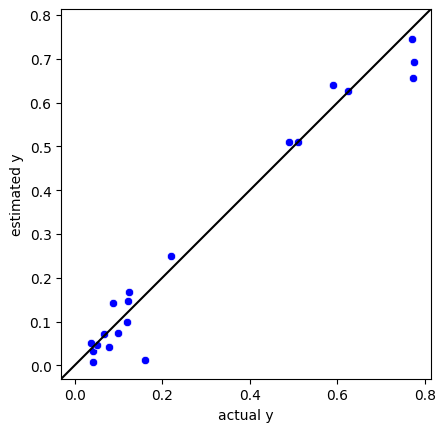

r^2 for training data : 0.9626474714375198
RMSE for training data : 0.05312835207520736
MAE for training data : 0.03772294067072186
sample number : 1 / 5
sample number : 2 / 5
sample number : 3 / 5
sample number : 4 / 5
sample number : 5 / 5


In [4]:
# 5.4.1 ベイズ最適化による実験候補の選択

import warnings

import polars as pl
from func import (
    autoscaling,
    calc_acquisition_func,
    calc_r2,
    delete_zero_std_columns,
    generate_kernels,
    load_data,
    rescaling,
    scatter_plot_of_result,
    show_fitting_evaluation,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import KFold, cross_val_predict

warnings.filterwarnings("ignore")

number_of_selecting_samples = 5  # 選択するサンプル数
regression_method = "gpr_one_kernel"  # gpr_one_kernel', 'gpr_kernels'
acquisition_function = "PTR"  # 'PTR', 'PI', 'EI', 'MI'

fold_number = 10  # クロスバリデーションの fold 数
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
target_range = [0, 1]  # PTR
relaxation = 0.01  # EI, PI
delta = 1e-6  # MI

# トレーニングデータの読み込み
dataset_train, index_train = load_data("../test_data/resin.csv", index="")
# データ分割
y_train = dataset_train.get_column("property")  # 目的変数
x_train = dataset_train.drop(y_train.name)  # 説明変数
# 予測データの読み込み
dataset_pred, index_pred = load_data("../output/05_02/remaining_samples.csv", index="")
x_pred = dataset_pred.clone()

# 標準偏差が 0 の特徴量の削除
x_train = delete_zero_std_columns(x_train)
x_pred = x_pred.select(x_train.columns)
# インデックスを結合(後で使用するため)
x_pred_wt_idx = x_pred.clone().insert_column(0, index_pred)

# カーネル 11 種類
kernels = generate_kernels(x_train)

# Bayesian optimization
# 次のサンプルを入れる変数を準備
next_samples = pl.DataFrame(schema=x_pred_wt_idx.schema)
for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y_train = autoscaling(y_train)
    autoscaled_x_train = autoscaling(x_train)
    autoscaled_x_pred = autoscaling(x_pred, x_train)

    # モデル構築
    if regression_method == "gpr_one_kernel":
        selected_kernel = kernels[kernel_number]
        model = GaussianProcessRegressor(
            alpha=0, kernel=selected_kernel, random_state=99
        )

    elif regression_method == "gpr_kernels":
        # クロスバリデーションによるカーネル関数の最適化
        # クロスバリデーションの分割の設定
        cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
        r2_cvs = pl.Series(
            "r2_cvs",
            [
                calc_r2(
                    GaussianProcessRegressor,
                    autoscaled_x_train,
                    autoscaled_y_train,
                    cv,
                    y_train,
                    kernel=kernel,
                    random_state=99,
                )
                for kernel in kernels
            ],
        )
        optimal_kernel = kernels[r2_cvs.arg_max()]  # r2が最も大きい(最適な)カーネル関数
        print("クロスバリデーションで選択されたカーネル関数 :", optimal_kernel)

        # モデル構築 GPR モデルの宣言
        model = GaussianProcessRegressor(
            alpha=0, kernel=optimal_kernel, random_state=99
        )

    model.fit(autoscaled_x_train, autoscaled_y_train)  # モデル構築

    if sample_number == 0:
        # トレーニングデータの推定
        autoscaled_estimated_y, autoscaled_estimated_y_std = model.predict(
            autoscaled_x_train, return_std=True
        )
        estimated_y = rescaling(
            pl.Series("estimated_y", autoscaled_estimated_y), y_train
        )
        estimated_y_std = rescaling(
            pl.Series("std_of_estimated_y", autoscaled_estimated_y_std),
            y_train,
            is_std=True,
        )

        # トレーニングデータの実測値 vs. 推定値のプロット
        scatter_plot_of_result(
            f"../output/05_04/05_04_01/actual_vs_estimated_y_{regression_method}.png",
            y_train,
            estimated_y,
            "actual y",
            "estimated y",
        )

        # トレーニングデータのr2, RMSE, MAE
        show_fitting_evaluation(y_train, estimated_y)

        # トレーニングデータの結果の保存
        pl.DataFrame(
            {
                "": index_train,
                "actual_y": y_train,
                "estimated_y": estimated_y,
                "error_of_y(actual_y-estimated_y)": y_train - estimated_y,
                "std_of_estimated_y": estimated_y_std,
            }
        ).write_csv(
            f"../output/05_04/05_04_01/estimated_y_in_detail_{regression_method}.csv",
            quote_style="never",
        )

        # クロスバリデーションによる y の値の推定
        cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
        autoscaled_estimated_y_in_cv = pl.Series(
            cross_val_predict(model, autoscaled_x_train, autoscaled_y_train, cv=cv)
        )
        estimated_y_in_cv = rescaling(autoscaled_estimated_y_in_cv, y_train)

        # クロスバリデーションにおける実測値 vs. 推定値のプロット
        scatter_plot_of_result(
            f"../output/05_04/05_04_01/actual_vs_estimated_y_in_cv_{regression_method}.png",
            y_train,
            estimated_y_in_cv,
            "actual y",
            "estimated y",
        )

        # クロスバリデーションにおけるr2, RMSE, MAE
        show_fitting_evaluation(y_train, estimated_y_in_cv)

        # クロスバリデーションの結果の保存
        pl.DataFrame(
            {
                "": index_train,
                "actual_y": y_train,
                "estimated_y": estimated_y_in_cv,
                "error_of_y(actual_y-estimated_y)": y_train - estimated_y_in_cv,
            }
        ).write_csv(
            f"../output/05_04/05_04_01/estimated_y_in_cv_in_detail_{regression_method}.csv",
            quote_style="never",
        )

    # 予測
    estimated_y_pred, estimated_y_pred_std = model.predict(
        autoscaled_x_pred, return_std=True
    )
    # スケールを戻す
    estimated_y_pred = rescaling(pl.Series(estimated_y_pred), y_train)
    estimated_y_pred_std = rescaling(
        pl.Series(estimated_y_pred_std), y_train, is_std=True
    )

    # 獲得関数の計算
    acquisition_function_prediction, cumulative_variance = calc_acquisition_func(
        estimated_y_pred,
        estimated_y_pred_std,
        acquisition_function,
        target_range,
        relaxation,
        delta,
    )

    # csv保存
    if sample_number == 0:
        pl.DataFrame(
            {
                "": index_pred,
                "estimated_y": estimated_y_pred,
                "std_of_estimated_y": estimated_y_pred_std,
            }
        ).write_csv(
            f"../output/05_04/05_04_01/estimated_y_prediction_{regression_method}.csv"
        )
        pl.DataFrame(
            {
                "": index_pred,
                "acquisition_function": acquisition_function_prediction,
            }
        ).write_csv(
            f"../output/05_04/05_04_01/acquisition_function_prediction_{regression_method}_{acquisition_function}.csv",
            quote_style="never",
        )

    # 獲得関数から選択されたサンプルのインデックス
    next_id = acquisition_function_prediction.arg_max()
    # 次のサンプル
    next_sample = x_pred_wt_idx.slice(next_id, 1)
    next_index = next_sample.item(0, index_pred.name)
    next_samples = next_samples.vstack(next_sample)

    next_y = estimated_y_pred.clone().slice(next_id, 1)

    # x, y, x_prediction, cumulative_variance の更新
    x_train = x_train.vstack(next_sample.drop(index_pred.name))
    y_train = y_train.append(next_y)
    x_pred_wt_idx = x_pred_wt_idx.filter(~pl.col(index_pred.name).is_in([next_index]))
    index_pred = x_pred_wt_idx[index_pred.name]
    x_pred = x_pred_wt_idx.drop(index_pred.name)
    mask = ~pl.Series(range(len(cumulative_variance))).is_in([next_id])
    cumulative_variance = cumulative_variance.filter(mask)
    print(f"sample number : {sample_number + 1} / {number_of_selecting_samples}")


next_samples.write_csv(
    f"../output/05_04/05_04_01/next_samples_bo_{regression_method}_{acquisition_function}.csv"
)


## 5.4.2 目的変数が複数ある場合

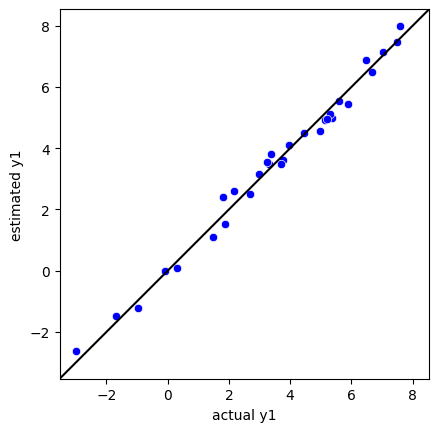

r^2 for training data : 0.9882778732200865
RMSE for training data : 0.2890448348249069
MAE for training data : 0.2525841296818685


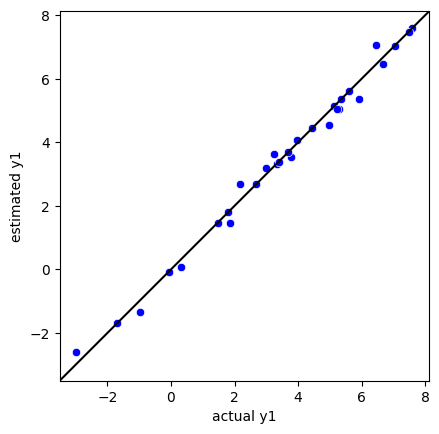

r^2 for training data : 0.9905900235128929
RMSE for training data : 0.2589740657763206
MAE for training data : 0.16883695796595422


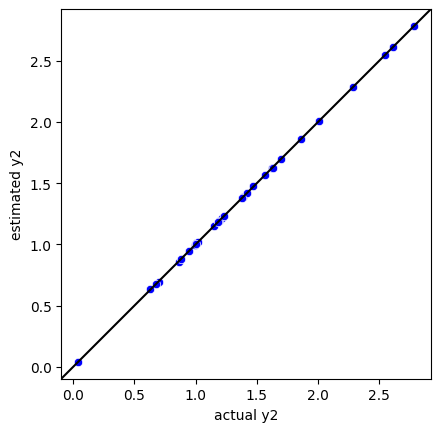

r^2 for training data : 0.9999828047597327
RMSE for training data : 0.002549452347370697
MAE for training data : 0.0018634948245206666


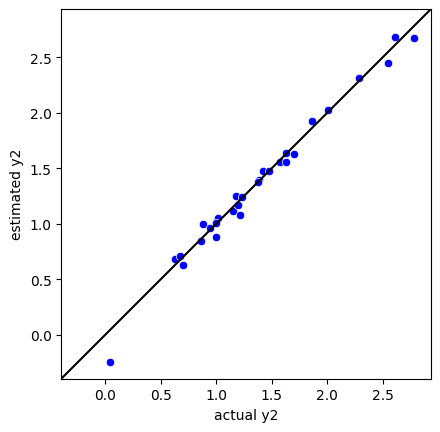

r^2 for training data : 0.9829682399855142
RMSE for training data : 0.08023660402422791
MAE for training data : 0.05683673725880419


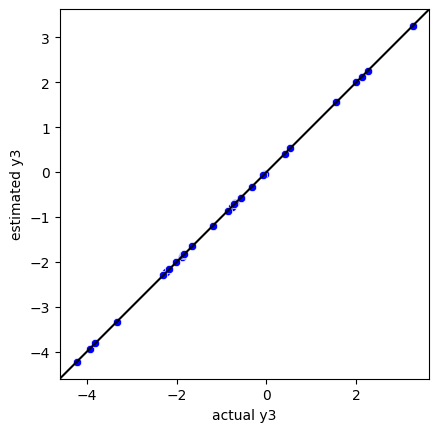

r^2 for training data : 0.9999999291397439
RMSE for training data : 0.0005018762089199569
MAE for training data : 0.00028251332812441324


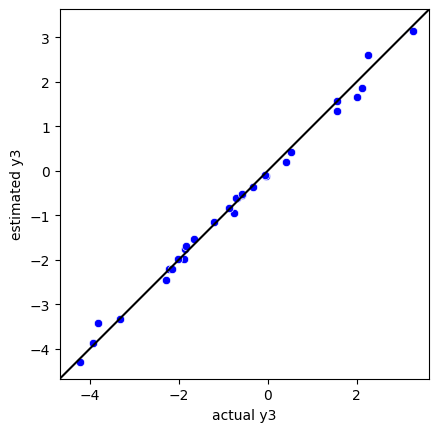

r^2 for training data : 0.993193900379262
RMSE for training data : 0.15554082593239954
MAE for training data : 0.11649641794823715


In [ ]:
# 5.4.2 目的変数が複数ある場合

import warnings

import polars as pl
from func import (
    autoscaling,
    calc_r2,
    delete_zero_std_columns,
    generate_kernels,
    load_data,
    rescaling,
    scatter_plot_of_result,
    show_fitting_evaluation,
)
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import KFold, cross_val_predict

warnings.filterwarnings("ignore")

regression_method = "gpr_one_kernel"  # gpr_one_kernel', 'gpr_kernels'

fold_number = 10  # クロスバリデーションの fold 数
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
relaxation = 0.01  # PI

dataset_train, index_train = load_data(
    "../test_data/training_data_multi_y.csv", index=""
)
x_pred, index_pred = load_data("../test_data/x_for_prediction_multi_y.csv", index="")
x_pred_wt_idx = x_pred.clone().insert_column(0, index_pred)
settings, setting_items = load_data(
    "../test_data/settings_in_bayesian_optimization_multi_y.csv", index=""
)
max_min_range_index = setting_items.index_of(
    "maximization(1)_or_minimization(-1)_or_range(0)"
)
ll_index = setting_items.index_of("lower_limit")
ul_index = setting_items.index_of("upper_limit")

# check datasets and settings
if not settings.width == (dataset_train.width - x_pred.width):
    raise Exception(
        "Check the numbers of y-variables and X-variables in training_data.csv, data_for_prediction.csv and settings.csv."
    )
for y_col in settings.iter_columns():
    if y_col.item(max_min_range_index) == 0 and (
        y_col.item(ll_index) >= y_col.item(ul_index)
    ):
        raise Exception(
            "`lower_limit` must be lower than `upper_limit` in settings.csv."
        )

# データ分割
y_train = dataset_train.select(settings.columns)  # 目的変数
x_train = dataset_train.drop(y_train.columns)  # 説明変数

# 標準偏差が 0 の特徴量の削除
x_train = delete_zero_std_columns(x_train)
x_pred = x_pred.select(x_train.columns)

# カーネル 11 種類
kernels = generate_kernels(x_train)

# オートスケーリング
autoscaled_y_train = autoscaling(y_train)
autoscaled_x_train = autoscaling(x_train)
autoscaled_x_pred = autoscaling(x_pred, x_train)
mean_of_y_train = y_train.mean()
std_of_y_train = y_train.std()

# Y ごとのモデル構築、予測
# Y の予測値を入れる変数
estimated_y_pred_all = pl.DataFrame({"": index_pred})
# Y の予測値の標準偏差を入れる変数
std_of_estimated_y_pred_all = pl.DataFrame({"": index_pred})
# Y の目標達成確率を入れる変数
probabilities_pred_all = pl.DataFrame({"": index_pred})
for target_autoscaled_y_train in autoscaled_y_train.iter_columns():
    # モデル構築
    if regression_method == "gpr_one_kernel":
        selected_kernel = kernels[kernel_number]
        model = GaussianProcessRegressor(
            alpha=0, kernel=selected_kernel, random_state=99
        )
    elif regression_method == "gpr_kernels":
        # クロスバリデーションによるカーネル関数の最適化
        # クロスバリデーションの分割の設定
        cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
        r2_cvs = pl.Series(
            "r2_cvs",
            [
                calc_r2(
                    GaussianProcessRegressor,
                    autoscaled_x_train,
                    target_autoscaled_y_train,
                    cv,
                    y_train,
                    kernel=kernel,
                    random_state=99,
                )
                for kernel in kernels
            ],
        )
        optimal_kernel = kernels[r2_cvs.arg_max()]  # r2が最も大きい(最適な)カーネル関数
        print("クロスバリデーションで選択されたカーネル関数 :", optimal_kernel)

        # モデル構築
        # GPR モデルの宣言
        model = GaussianProcessRegressor(
            alpha=0, kernel=optimal_kernel, random_state=99
        )

    model.fit(autoscaled_x_train, target_autoscaled_y_train)  # モデル構築

    # トレーニングデータの推定
    # y の推定
    autoscaled_estimated_y, autoscaled_estimated_y_std = model.predict(
        autoscaled_x_train, return_std=True
    )
    target_y_train = y_train.get_column(target_autoscaled_y_train.name)
    # スケールをもとに戻す
    estimated_y = rescaling(
        pl.Series("estimated_y", autoscaled_estimated_y), target_y_train
    )
    estimated_y_std = rescaling(
        pl.Series("std_of_estimated_y", autoscaled_estimated_y_std),
        target_y_train,
        is_std=True,
    )

    # トレーニングデータの実測値 vs. 推定値のプロット
    scatter_plot_of_result(
        f"../output/05_04/05_04_02/actual_vs_estimated_multi_y_{regression_method}_{target_y_train.name}.png",
        target_y_train,
        estimated_y,
        f"actual {target_y_train.name}",
        f"estimated {target_y_train.name}",
    )

    # トレーニングデータのr2, RMSE, MAE
    show_fitting_evaluation(target_y_train, estimated_y)

    # トレーニングデータの結果の保存
    pl.DataFrame(
        {
            "": index_train,
            "actual_y": target_y_train,
            "estimated_y": estimated_y,
            "error_of_y(actual_y-estimated_y)": target_y_train - estimated_y,
            "std_of_estimated_y": estimated_y_std,
        }
    ).write_csv(
        f"../output/05_04/05_04_02/estimated_y_in_detail_multi_y_{regression_method}_{target_y_train.name}.csv"
    )

    # クロスバリデーションによる y の値の推定
    # クロスバリデーションの分割の設定
    cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)

    # yの推定
    autoscaled_estimated_y_in_cv = cross_val_predict(
        model,
        autoscaled_x_train,
        autoscaled_y_train.get_column(target_y_train.name),
        cv=cv,
    )
    # スケールをもとに戻す
    estimated_y_in_cv = rescaling(
        pl.Series("estimated_y", autoscaled_estimated_y_in_cv),
        y_train.get_column(target_y_train.name),
    )

    # クロスバリデーションにおける実測値 vs. 推定値のプロット
    scatter_plot_of_result(
        f"../output/05_04/05_04_02/actual_vs_estimated_in_cv_multi_y_{regression_method}_{target_y_train.name}.png",
        target_y_train,
        estimated_y_in_cv,
        f"actual {target_y_train.name}",
        f"estimated {target_y_train.name}",
    )

    # クロスバリデーションにおけるr2, RMSE, MAE
    show_fitting_evaluation(target_y_train, estimated_y_in_cv)

    # クロスバリデーションの結果の保存
    pl.DataFrame(
        {
            "": index_train,
            "actual_y": target_y_train,
            "estimated_y": estimated_y_in_cv,
            "error_of_y(actual_y-estimated_y)": target_y_train - estimated_y_in_cv,
        }
    ).write_csv(
        f"../output/05_04/05_04_02/estimated_y_in_cv_in_detail_multi_y_{regression_method}_{target_y_train.name}.csv"
    )

    # 予測
    estimated_y_pred, estimated_y_pred_std = model.predict(
        autoscaled_x_pred, return_std=True
    )
    estimated_y_pred = rescaling(
        pl.Series("estimated_y", estimated_y_pred), target_y_train
    )
    estimated_y_pred_std = rescaling(
        pl.Series("std_of_estimated_y", estimated_y_pred_std),
        target_y_train,
        is_std=True,
    )

    # 獲得関数 (目標達成確率) の計算
    mode = settings.item(max_min_range_index, target_y_train.name)
    if mode == 1:
        probabilities_prediction = 1 - norm.cdf(
            target_y_train.max() + target_y_train.std() * relaxation,
            loc=estimated_y_pred,
            scale=estimated_y_pred_std,
        )
    elif mode == -1:
        probabilities_prediction = norm.cdf(
            target_y_train.min() - target_y_train.std() * relaxation,
            loc=estimated_y_pred,
            scale=estimated_y_pred_std,
        )

    elif mode == 0:
        probabilities_prediction = norm.cdf(
            settings.item(ul_index, target_y_train.name),
            loc=estimated_y_pred,
            scale=estimated_y_pred_std,
        ) - norm.cdf(
            settings.item(ll_index, target_y_train.name),
            loc=estimated_y_pred,
            scale=estimated_y_pred_std,
        )
    probabilities_prediction[estimated_y_pred_std <= 0] = 0

    # 格納
    # Y の予測値
    estimated_y_pred_all = estimated_y_pred_all.with_columns(
        pl.Series(target_y_train.name, estimated_y_pred)
    )
    # Y の予測値の標準偏差
    std_of_estimated_y_pred_all = std_of_estimated_y_pred_all.with_columns(
        pl.Series(target_y_train.name, estimated_y_pred_std)
    )
    # Y の目標達成確率
    probabilities_pred_all = probabilities_pred_all.with_columns(
        pl.Series(target_y_train.name, probabilities_prediction)
    )


# 目標達成確率の対数の和
sum_of_log_prob = probabilities_pred_all.with_columns(pl.all().log()).sum_horizontal()

# 保存
# 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
estimated_y_pred_all.write_csv(
    f"../output/05_04/05_04_02/estimated_y_prediction_multi_y_{regression_method}.csv",
    quote_style="never",
)
# 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
std_of_estimated_y_pred_all.write_csv(
    f"../output/05_04/05_04_02/estimated_y_prediction_multi_y_std_{regression_method}.csv",
    quote_style="never",
)

# 獲得関数 (目標達成確率) を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
probabilities_pred_all.write_csv(
    f"../output/05_04/05_04_02/probabilities_prediction_multi_y_{regression_method}.csv",
    quote_style="never",
)
pl.DataFrame(
    {"": index_pred, "sum_of_log_probabilities": sum_of_log_prob},
).write_csv(
    f"../output/05_04/05_04_02/sum_of_log_probabilities_prediction_multi_y_{regression_method}.csv",
    quote_style="never",
)

# 次のサンプル
x_pred_wt_idx.slice(sum_of_log_prob.arg_max(), 1).write_csv(
    f"../output/05_04/05_04_02/next_sample_bo_multi_y_{regression_method}.csv",
    quote_style="never",
)


## 5.4.3 目的変数が複数あり、複数のサンプルを選択する場合

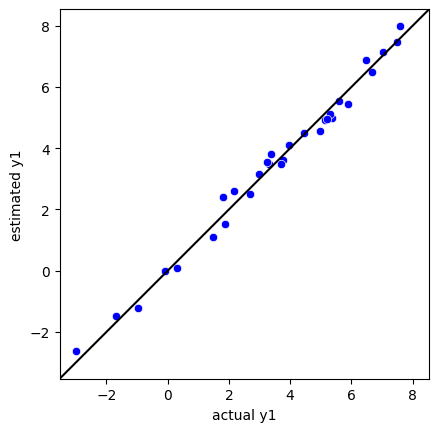

r^2: 0.9882778732200865
RMSE: 0.2890448348249069
MAE: 0.2525841296818685


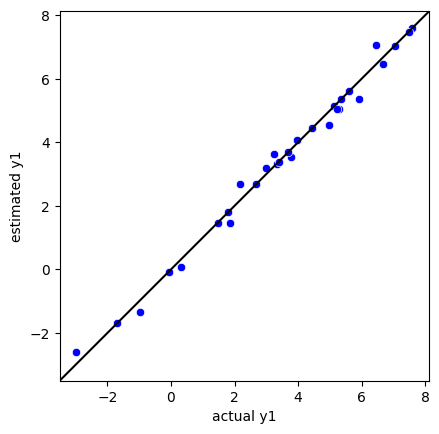

r^2: 0.9905900235128929
RMSE: 0.2589740657763206
MAE: 0.16883695796595422


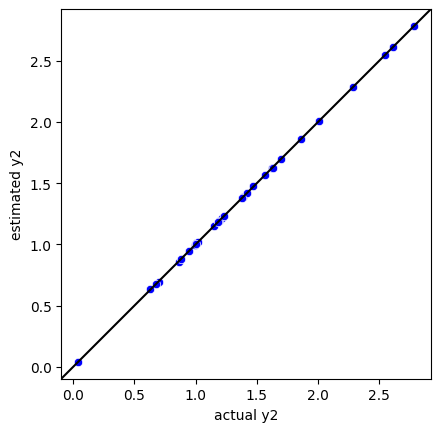

r^2: 0.9999828047597327
RMSE: 0.002549452347370697
MAE: 0.0018634948245206666


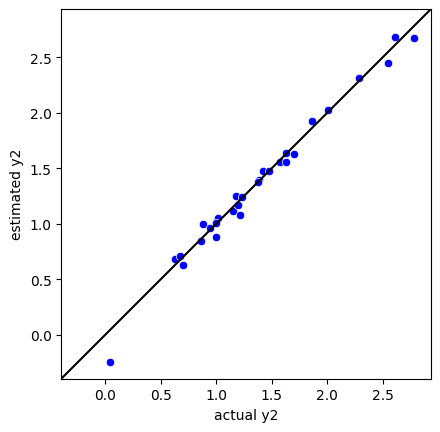

r^2: 0.9829682399855142
RMSE: 0.08023660402422791
MAE: 0.05683673725880419


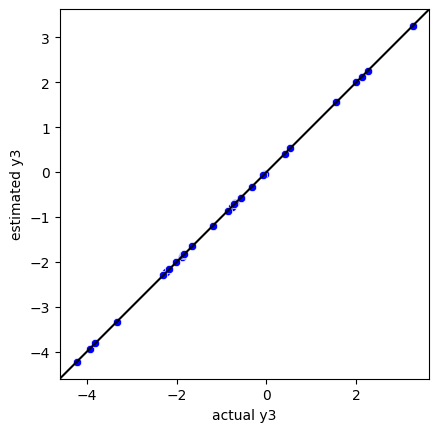

r^2: 0.9999999291397439
RMSE: 0.0005018762089199569
MAE: 0.00028251332812441324


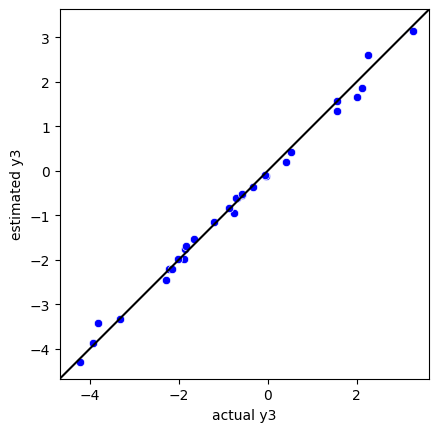

r^2: 0.993193900379262
RMSE: 0.15554082593239954
MAE: 0.11649641794823715
sample number : 1 / 5
sample number : 2 / 5
sample number : 3 / 5
sample number : 4 / 5
sample number : 5 / 5


In [ ]:
# 5.4.3

import warnings

import polars as pl
from func import (
    autoscaling,
    calc_r2,
    delete_zero_std_columns,
    generate_kernels,
    load_data,
    rescaling,
    scatter_plot_of_result,
    show_fitting_evaluation,
)
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import KFold, cross_val_predict

warnings.filterwarnings("ignore")

number_of_selecting_samples = 5  # 選択するサンプル数
regression_method = "gpr_one_kernel"  # gpr_one_kernel', 'gpr_kernels'

fold_number = 10  # クロスバリデーションの fold 数
kernel_number = 2  # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
relaxation = 0.01  # MI, EI, PI

dataset_train, index_train = load_data(
    "../test_data/training_data_multi_y.csv", index=""
)
x_pred, index_pred = load_data("../test_data/x_for_prediction_multi_y.csv", index="")
x_pred_wt_idx = x_pred.clone().insert_column(0, index_pred)
settings, setting_items = load_data(
    "../test_data/settings_in_bayesian_optimization_multi_y.csv", index=""
)
max_min_range_index = setting_items.index_of(
    "maximization(1)_or_minimization(-1)_or_range(0)"
)
ll_index = setting_items.index_of("lower_limit")
ul_index = setting_items.index_of("upper_limit")

# check datasets and settings
if not settings.width == (dataset_train.width - x_pred.width):
    raise Exception(
        "Check the numbers of y-variables and X-variables in training_data.csv, data_for_prediction.csv and settings.csv."
    )
for y_col in settings.iter_columns():
    if y_col.item(max_min_range_index) == 0 and (
        y_col.item(ll_index) >= y_col.item(ul_index)
    ):
        raise Exception(
            "`lower_limit` must be lower than `upper_limit` in settings.csv."
        )

# データ分割
y_train = dataset_train.select(settings.columns)  # 目的変数
x_train = dataset_train.drop(y_train.columns)  # 説明変数
x_train_wt_idx = x_train.clone().insert_column(0, index_train)
# インデックスを結合(後で使用するため)

# 標準偏差が 0 の特徴量の削除
x_train = delete_zero_std_columns(x_train)
x_pred = x_pred.select(x_train.columns)

# カーネル 11 種類
kernels = generate_kernels(x_train)

# Bayesian optimization
# 次のサンプルを入れる変数を準備
next_samples = pl.DataFrame(schema=x_pred_wt_idx.schema)
for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y_train = autoscaling(y_train)
    autoscaled_x_train = autoscaling(x_train)
    autoscaled_x_pred = autoscaling(x_pred, x_train)
    mean_of_y_train = y_train.mean()
    std_of_y_train = y_train.std()

    # Y の予測値を入れる変数
    estimated_y_pred_all = pl.DataFrame({"": index_pred})
    # Y の予測値の標準偏差を入れる変数
    std_of_estimated_y_pred_all = pl.DataFrame({"": index_pred})
    # Y の目標達成確率を入れる変数
    probabilities_pred_all = pl.DataFrame({"": index_pred})
    # Y ごとのモデル構築、予測
    for target_autoscaled_y_train in autoscaled_y_train.iter_columns():
        target_y_train = y_train.get_column(target_autoscaled_y_train.name)
        # カーネルの選択
        if regression_method == "gpr_one_kernel":
            selected_kernel = kernels[kernel_number]
        elif regression_method == "gpr_kernels":
            # クロスバリデーションによるカーネル関数の最適化
            # クロスバリデーションの分割の設定
            cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)
            r2_cvs = pl.Series(
                "r2_cvs",
                [
                    calc_r2(
                        GaussianProcessRegressor,
                        autoscaled_x_train,
                        target_autoscaled_y_train,
                        cv,
                        y_train,
                        kernel=kernel,
                        random_state=99,
                    )
                    for kernel in kernels
                ],
            )
            # r2が最も大きい(最適な)カーネル関数
            selected_kernel = kernels[r2_cvs.arg_max()]
            print("クロスバリデーションで選択されたカーネル関数 :", selected_kernel)

        # モデル構築
        # GPR モデルの宣言
        model = GaussianProcessRegressor(
            alpha=0, kernel=selected_kernel, random_state=99
        )
        model.fit(autoscaled_x_train, target_autoscaled_y_train)

        if sample_number == 0:
            # トレーニングデータの推定
            # y の推定
            autoscaled_estimated_y, autoscaled_estimated_y_std = model.predict(
                autoscaled_x_train, return_std=True
            )
            # スケールをもとに戻す
            estimated_y = rescaling(
                pl.Series("estimated_y", autoscaled_estimated_y), target_y_train
            )
            estimated_y_std = rescaling(
                pl.Series("std_of_estimated_y", autoscaled_estimated_y_std),
                target_y_train,
                is_std=True,
            )

            # トレーニングデータの実測値 vs. 推定値のプロット
            scatter_plot_of_result(
                f"../output/05_04/05_04_03/estimated_y_in_training_data_{regression_method}_{target_y_train.name}.png",
                target_y_train,
                estimated_y,
                f"actual {target_y_train.name}",
                f"estimated {target_y_train.name}",
            )

            # トレーニングデータのr2, RMSE, MAE
            show_fitting_evaluation(target_y_train, estimated_y)

            # トレーニングデータの結果の保存
            pl.DataFrame(
                {
                    "": index_train,
                    "actual_y": target_y_train,
                    "estimated_y": estimated_y,
                    "error_of_y(actual_y-estimated_y)": target_y_train - estimated_y,
                    "std_of_estimated_y": estimated_y_std,
                }
            ).write_csv(
                f"../output/05_04/05_04_03/estimated_y_in_detail_{regression_method}_{target_y_train.name}.csv"
            )

            # クロスバリデーションによる y の値の推定
            # クロスバリデーションの分割の設定
            cv = KFold(n_splits=fold_number, random_state=9, shuffle=True)

            # yの推定
            autoscaled_estimated_y_in_cv = cross_val_predict(
                model,
                autoscaled_x_train,
                autoscaled_y_train.get_column(target_y_train.name),
                cv=cv,
            )
            # スケールをもとに戻す
            estimated_y_in_cv = rescaling(
                pl.Series("estimated_y", autoscaled_estimated_y_in_cv),
                target_y_train,
            )

            # クロスバリデーションにおける実測値 vs. 推定値のプロット
            scatter_plot_of_result(
                f"../output/05_04/05_04_03/actual_vs_estimated_in_cv_{regression_method}_{target_y_train.name}.png",
                target_y_train,
                estimated_y_in_cv,
                f"actual {target_y_train.name}",
                f"estimated {target_y_train.name}",
            )

            # クロスバリデーションにおけるr2, RMSE, MAE
            show_fitting_evaluation(target_y_train, estimated_y_in_cv)

            # クロスバリデーションの結果の保存
            pl.DataFrame(
                {
                    "": index_train,
                    "actual_y": target_y_train,
                    "estimated_y": estimated_y_in_cv,
                    "error_of_y(actual_y-estimated_y)": target_y_train
                    - estimated_y_in_cv,
                }
            ).write_csv(
                f"../output/05_04/05_04_03/estimated_y_in_cv_in_detail_{regression_method}_{target_y_train.name}.csv"
            )

        # 予測
        estimated_y_pred, estimated_y_pred_std = model.predict(
            autoscaled_x_pred, return_std=True
        )
        estimated_y_pred = rescaling(
            pl.Series("estimated_y", estimated_y_pred), target_y_train
        )
        estimated_y_pred_std = rescaling(
            pl.Series("std_of_estimated_y", estimated_y_pred_std),
            target_y_train,
            is_std=True,
        )

        # 獲得関数 (目標達成確率) の計算
        mode = settings.item(max_min_range_index, target_y_train.name)
        if mode == 1:
            probabilities_prediction = 1 - norm.cdf(
                target_y_train.max() + target_y_train.std() * relaxation,
                loc=estimated_y_pred,
                scale=estimated_y_pred_std,
            )
        elif mode == -1:
            probabilities_prediction = norm.cdf(
                target_y_train.min() - target_y_train.std() * relaxation,
                loc=estimated_y_pred,
                scale=estimated_y_pred_std,
            )

        elif mode == 0:
            probabilities_prediction = norm.cdf(
                settings.item(ul_index, target_y_train.name),
                loc=estimated_y_pred,
                scale=estimated_y_pred_std,
            ) - norm.cdf(
                settings.item(ll_index, target_y_train.name),
                loc=estimated_y_pred,
                scale=estimated_y_pred_std,
            )
        probabilities_prediction[estimated_y_pred_std <= 0] = 0

        # 格納
        # Y の予測値
        estimated_y_pred_all = estimated_y_pred_all.with_columns(
            pl.Series(target_y_train.name, estimated_y_pred)
        )
        # Y の予測値の標準偏差
        std_of_estimated_y_pred_all = std_of_estimated_y_pred_all.with_columns(
            pl.Series(target_y_train.name, estimated_y_pred_std)
        )
        # Y の目標達成確率
        probabilities_pred_all = probabilities_pred_all.with_columns(
            pl.Series(target_y_train.name, probabilities_prediction)
        )

    # 目標達成確率の対数の和
    sum_of_log_prob = probabilities_pred_all.with_columns(
        pl.all().log()
    ).sum_horizontal()

    if sample_number == 0:
        estimated_y_pred_all.write_csv(
            f"../output/05_04/05_04_03/estimated_y_prediction_multi_y_{regression_method}.csv",
            quote_style="never",
        )
        std_of_estimated_y_pred_all.write_csv(
            f"../output/05_04/05_04_03/estimated_y_prediction_multi_y_std_{regression_method}.csv",
            quote_style="never",
        )
        probabilities_pred_all.write_csv(
            f"../output/05_04/05_04_03/probabilities_prediction_multi_y_{regression_method}.csv",
            quote_style="never",
        )
        pl.DataFrame(
            {"": index_pred, "sum_of_log_probabilities": sum_of_log_prob},
        ).write_csv(
            f"../output/05_04/05_04_03/sum_of_log_probabilities_prediction_multi_y_{regression_method}.csv",
            quote_style="never",
        )

    # 次のサンプル
    next_id = sum_of_log_prob.arg_max()
    next_sample = x_pred_wt_idx.slice(next_id, 1)
    next_index: int = next_sample.item(0, index_pred.name)
    next_samples = next_samples.vstack(next_sample)
    next_y = estimated_y_pred_all.drop("").slice(next_id, 1)

    # x, y, x_pred の更新
    x_train = x_train.vstack(next_sample.drop(index_pred.name))
    y_train = y_train.vstack(next_y)
    x_pred_wt_idx = x_pred_wt_idx.filter(~pl.col(index_pred.name).is_in([next_index]))
    index_pred = x_pred_wt_idx[index_pred.name]
    x_pred = x_pred_wt_idx.drop(index_pred.name)
    print(f"sample number : {sample_number + 1} / {number_of_selecting_samples}")

next_samples.write_csv(
    f"../output/05_04/05_04_03/next_samples_bo_multi_y_{regression_method}.csv",
    quote_style="never",
)


## 5.5 化学構造を扱うときはどうするか

In [ ]:
# 5.5 SMILESデータセットがcsvの場合の分子記述子計算

import polars as pl
from func import load_data
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from tqdm.notebook import tqdm

# SMILES 付きデータセットの読み込み
dataset, index = load_data("../test_data/molecules.csv", index="")
smiles = dataset.get_column("SMILES")
print("分子の数 :", smiles.len())
if dataset.width > 1:
    y = dataset.drop(smiles.name)

# 計算する記述子名の取得
descriptor_names = [descriptor_info[0] for descriptor_info in Descriptors.descList]
print("計算する記述子の数 :", len(descriptor_names))

# 記述子の計算
descriptor_calc = md.MolecularDescriptorCalculator(descriptor_names)
# ここに計算された記述子の値を追加
descriptors = [
    descriptor_calc.CalcDescriptors(Chem.MolFromSmiles(smiles_item))
    for smiles_item in tqdm(smiles)
]
descriptors = pl.DataFrame(descriptors, schema=descriptor_names)
if dataset.width > 1:
    descriptors = y.hstack(descriptors)  # y と記述子を結合
descriptors.insert_column(0, index)  # インデックスを追加

# 保存
descriptors.write_csv("../output/05_05/csv_descriptors.csv", quote_style="never")


分子の数 : 1290
計算する記述子の数 : 217


  0%|          | 0/1290 [00:00<?, ?it/s]

## 5.5 sdfファイルの読み込み

In [ ]:
# 5.5 SMILESデータセットがsdfの場合の分子記述子計算

import polars as pl
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from tqdm.notebook import tqdm

property_name = "logS"  # sdf ファイルの property の名前。property がない場合は何も書かないでください(property_name = '')

molecules = Chem.SDMolSupplier("../test_data/molecules.sdf")  # sdf ファイルの読み込み
print("分子の数 :", len(molecules))

# 計算する記述子名の取得
descriptor_names = [
    descriptor_information[0] for descriptor_information in Descriptors.descList
]
print("計算する記述子の数 :", len(descriptor_names))

# 記述子の計算
descriptor_calc = md.MolecularDescriptorCalculator(descriptor_names)
# 分子ごとに、リスト型の変数 y に物性値を、descriptors に計算された記述子の値を、smiles に SMILES を追加
descriptors, y, smiles = [], [], []
for molecule in tqdm(molecules):
    if len(property_name):
        y.append(float(molecule.GetProp(property_name)))
    descriptors.append(descriptor_calc.CalcDescriptors(molecule))
    smiles.append(Chem.MolToSmiles(molecule))
descriptors = pl.DataFrame(descriptors, schema=descriptor_names)
if len(property_name):
    y = pl.DataFrame({property_name: y})
    descriptors = y.hstack(descriptors)  # y と記述子を結合
descriptors.insert_column(0, pl.Series("", smiles))  # インデックスを追加

# 保存
# csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
descriptors.write_csv("../output/05_05/sdf_descriptors.csv", quote_style="never")


分子の数 : 1290
計算する記述子の数 : 217


  0%|          | 0/1290 [00:00<?, ?it/s]

## 5.5 分子構造の生成(BRICS)

In [ ]:
# 5.5 分子構造の生成(BRICS)

import polars as pl
from func import load_data
from rdkit import Chem
from rdkit.Chem import BRICS
from tqdm.notebook import tqdm

num_of_generating_structures = 100  # 繰り返し 1 回あたり生成する化学構造の数
number_of_iterations = 10  # 繰り返し回数。(number_of_generating_structures × number_of_iterations) 個の化学構造が生成されます

# 種構造の SMILES のデータセットの読み込み
dataset, index = load_data("../test_data/molecules.csv", index="")
molecules = [Chem.MolFromSmiles(smiles) for smiles in dataset.get_column("SMILES")]
print("種となる分子の数 :", len(molecules))

# フラグメントへの変換
fragments = set()
for molecule in molecules:
    fragment = BRICS.BRICSDecompose(molecule, minFragmentSize=1)
    fragments.update(fragment)
print("生成されたフラグメントの数 :", len(fragments))

# 化学構造生成
generated_structures = []
for gen_i in tqdm(range(number_of_iterations), desc="outer", position=0):
    generated_structures_all = BRICS.BRICSBuild(
        [Chem.MolFromSmiles(fragment) for fragment in fragments],
    )
    for index, generated_structure in tqdm(
        enumerate(generated_structures_all, 1),
        desc="inner",
        position=1,
        leave=False,
    ):
        generated_structure.UpdatePropertyCache(True)
        generated_structures.append(Chem.MolToSmiles(generated_structure))
        if index >= num_of_generating_structures:
            break
generated_structures = list(set(generated_structures))  # 重複する構造の削除
# csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
pl.DataFrame({"SMILES": generated_structures}).write_csv(
    "../output/05_05/generated_structures_brics.csv"
)

種となる分子の数 : 1290
生成されたフラグメントの数 : 1100


 outer:   0%|          | 0/10 [00:00<?, ?it/s]

inner: 0it [00:00, ?it/s]

inner: 0it [00:00, ?it/s]

inner: 0it [00:00, ?it/s]

inner: 0it [00:00, ?it/s]

inner: 0it [00:00, ?it/s]

inner: 0it [00:00, ?it/s]

inner: 0it [00:00, ?it/s]

inner: 0it [00:00, ?it/s]

inner: 0it [00:00, ?it/s]

inner: 0it [00:00, ?it/s]

## 5.5 分子構造の生成(フラグメント結合)

In [ ]:
# 5.5 分子構造の生成(フラグメント結合)

import numpy as np
import polars as pl
from rdkit import Chem
from func import load_data

num_of_generating_structures = 10000  # 生成する化学構造の数

# 主骨格のフラグメントの SMILES のデータセットの読み込み
dataset_main_fragments, index_main = load_data(
    "../test_data/main_fragments.csv", index=""
)
# 主骨格のフラグメントの SMILES
main_fragments = dataset_main_fragments.get_column("main_fragments")
# 側鎖のフラグメントの SMILES のデータセットの読み込み
dataset_sub_fragments, index_sub = load_data("../test_data/sub_fragments.csv", index="")
sub_fragments = dataset_sub_fragments.get_column("sub_fragments")

print("主骨格のフラグメントの数 :", main_fragments.len())
print("側鎖のフラグメントの数 :", sub_fragments.len())

main_molecules = [Chem.MolFromSmiles(smiles) for smiles in main_fragments]
fragment_molecules = [Chem.MolFromSmiles(smiles) for smiles in sub_fragments]
main_molecule_length = len(main_molecules)
sub_molecule_length = len(fragment_molecules)

bond_list = [
    Chem.rdchem.BondType.UNSPECIFIED,
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.QUADRUPLE,
    Chem.rdchem.BondType.QUINTUPLE,
    Chem.rdchem.BondType.HEXTUPLE,
    Chem.rdchem.BondType.ONEANDAHALF,
    Chem.rdchem.BondType.TWOANDAHALF,
    Chem.rdchem.BondType.THREEANDAHALF,
    Chem.rdchem.BondType.FOURANDAHALF,
    Chem.rdchem.BondType.FIVEANDAHALF,
    Chem.rdchem.BondType.AROMATIC,
    Chem.rdchem.BondType.IONIC,
    Chem.rdchem.BondType.HYDROGEN,
    Chem.rdchem.BondType.THREECENTER,
    Chem.rdchem.BondType.DATIVEONE,
    Chem.rdchem.BondType.DATIVE,
    Chem.rdchem.BondType.DATIVEL,
    Chem.rdchem.BondType.DATIVER,
    Chem.rdchem.BondType.OTHER,
    Chem.rdchem.BondType.ZERO,
]

generated_structures = []
rng = np.random.default_rng(99)
for gen_i in range(num_of_generating_structures):
    main_molecule = rng.choice(main_molecules)  # ランダムに主骨格を選択
    # make adjacency matrix and get atoms for main molecule
    main_adjacency_matrix = Chem.rdmolops.GetAdjacencyMatrix(main_molecule)
    for bond in main_molecule.GetBonds():
        main_adjacency_matrix[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()] = (
            bond_list.index(bond.GetBondType())
        )
        main_adjacency_matrix[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()] = (
            bond_list.index(bond.GetBondType())
        )

    main_atoms = [atom.GetSymbol() for atom in main_molecule.GetAtoms()]
    r_index_in_main_molecule_old = [
        index for index, atom in enumerate(main_atoms) if atom == "*"
    ]

    for i, r_index in enumerate(r_index_in_main_molecule_old):
        modified_index = r_index - i
        # 原子を取り出して後ろに再度追加
        atom = main_atoms.pop(modified_index)
        main_atoms.append(atom)
        # 近接行列の行と列を取り出して後ろに再度追加
        # 列
        tmp_col = main_adjacency_matrix[:, modified_index : modified_index + 1].copy()
        main_adjacency_matrix = np.delete(main_adjacency_matrix, modified_index, axis=1)
        main_adjacency_matrix = np.hstack([main_adjacency_matrix, tmp_col])
        # 行
        tmp_row = main_adjacency_matrix[modified_index : modified_index + 1, :].copy()
        main_adjacency_matrix = np.delete(main_adjacency_matrix, modified_index, 0)
        main_adjacency_matrix = np.vstack([main_adjacency_matrix, tmp_row])

    r_index_in_main_molecule_new = [
        i for i, atom in enumerate(main_atoms) if atom == "*"
    ]

    r_bonded_atom_index_in_main_molecule = [
        np.where(main_adjacency_matrix[number, :] != 0)[0][0]
        for number in r_index_in_main_molecule_new
    ]

    r_bond_number_in_main_molecule = main_adjacency_matrix[
        r_index_in_main_molecule_new, r_bonded_atom_index_in_main_molecule
    ]

    main_adjacency_matrix = np.delete(
        main_adjacency_matrix, r_index_in_main_molecule_new, 0
    )
    main_adjacency_matrix = np.delete(
        main_adjacency_matrix, r_index_in_main_molecule_new, 1
    )

    for i in range(len(r_index_in_main_molecule_new)):
        main_atoms.remove("*")
    main_size = main_adjacency_matrix.shape[0]

    selected_fragment_molecules = rng.choice(
        fragment_molecules, len(r_index_in_main_molecule_old)
    )

    generated_molecule_atoms = main_atoms[:]
    generated_adjacency_matrix = main_adjacency_matrix.copy()
    for r_number_in_molecule in range(len(r_index_in_main_molecule_new)):
        fragment_molecule = selected_fragment_molecules[r_number_in_molecule]
        fragment_adjacency_matrix = Chem.rdmolops.GetAdjacencyMatrix(fragment_molecule)
        for bond in fragment_molecule.GetBonds():
            fragment_adjacency_matrix[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()] = (
                bond_list.index(bond.GetBondType())
            )
            fragment_adjacency_matrix[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()] = (
                bond_list.index(bond.GetBondType())
            )
        fragment_atoms = []
        for atom in fragment_molecule.GetAtoms():
            fragment_atoms.append(atom.GetSymbol())

        # integrate adjacency matrix
        r_index_in_fragment_molecule = fragment_atoms.index("*")

        r_bonded_atom_index_in_fragment_molecule = np.where(
            fragment_adjacency_matrix[r_index_in_fragment_molecule, :] != 0
        )[0][0]
        if r_bonded_atom_index_in_fragment_molecule > r_index_in_fragment_molecule:
            r_bonded_atom_index_in_fragment_molecule -= 1

        fragment_atoms.remove("*")
        fragment_adjacency_matrix = np.delete(
            fragment_adjacency_matrix, r_index_in_fragment_molecule, 0
        )
        fragment_adjacency_matrix = np.delete(
            fragment_adjacency_matrix, r_index_in_fragment_molecule, 1
        )

        main_size = generated_adjacency_matrix.shape[0]
        generated_adjacency_matrix = np.c_[
            generated_adjacency_matrix,
            np.zeros(
                [
                    generated_adjacency_matrix.shape[0],
                    fragment_adjacency_matrix.shape[0],
                ],
                dtype="int32",
            ),
        ]
        generated_adjacency_matrix = np.r_[
            generated_adjacency_matrix,
            np.zeros(
                [
                    fragment_adjacency_matrix.shape[0],
                    generated_adjacency_matrix.shape[1],
                ],
                dtype="int32",
            ),
        ]

        generated_adjacency_matrix[
            r_bonded_atom_index_in_main_molecule[r_number_in_molecule],
            r_bonded_atom_index_in_fragment_molecule + main_size,
        ] = r_bond_number_in_main_molecule[r_number_in_molecule]
        generated_adjacency_matrix[
            r_bonded_atom_index_in_fragment_molecule + main_size,
            r_bonded_atom_index_in_main_molecule[r_number_in_molecule],
        ] = r_bond_number_in_main_molecule[r_number_in_molecule]
        generated_adjacency_matrix[main_size:, main_size:] = fragment_adjacency_matrix

        # integrate atoms
        generated_molecule_atoms += fragment_atoms

    # generate structures
    generated_molecule = Chem.RWMol()
    atom_index = []
    for atom_number in range(len(generated_molecule_atoms)):
        atom = Chem.Atom(generated_molecule_atoms[atom_number])
        molecular_index = generated_molecule.AddAtom(atom)
        atom_index.append(molecular_index)
    for index_x, row_vector in enumerate(generated_adjacency_matrix):
        for index_y, bond in enumerate(row_vector):
            if index_y <= index_x:
                continue
            if bond == 0:
                continue
            else:
                generated_molecule.AddBond(
                    atom_index[index_x], atom_index[index_y], bond_list[bond]
                )

    generated_molecule = generated_molecule.GetMol()
    generated_structures.append(Chem.MolToSmiles(generated_molecule))
    if (gen_i + 1) % 1000 == 0 or (gen_i + 1) == num_of_generating_structures:
        print(gen_i + 1, "/", num_of_generating_structures)

# 保存
pl.DataFrame({"SMILES": sorted(list(set(generated_structures)))}).with_row_index(
    ""
).write_csv(
    "../output/05_05/generated_structures_r_group.csv",
    quote_style="never",
)


主骨格のフラグメントの数 : 1424
側鎖のフラグメントの数 : 1641
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
10000 / 10000
